In [1]:
import pybedtools as pb
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import scipy.stats as stats
import tempfile
from plotnine import ggplot, aes, theme, labs, geom_bar, element_text, position_dodge, geom_text, theme_light, scale_fill_manual

from dnam_preprocessing import get_targeted_dnam, compute_obs_attributes
import filenames

# Get DNAm data at 10x and 100x coverage, with and without tadpole samples.
ad10_all, ad100_all, ad10, ad100, df_testset, ages_testset = get_targeted_dnam()
ad100_notadpoles = ad100.copy()
ad100_notadpoles = ad100_notadpoles[:, ~ad100_notadpoles.var['Is tadpole?']]
compute_obs_attributes(ad100_notadpoles)
ad10_notadpoles = ad10.copy()
ad10_notadpoles = ad10_notadpoles[:, ~ad10_notadpoles.var['Is tadpole?']]
compute_obs_attributes(ad10_notadpoles)

# Compute most significantly age-correlated CpGs based on Benjamini-Hochberg adjusted 
# p values of the spearman correlation (found in 'spearman_p')
FDR_LEVEL = 0.001
p_adj = stats.false_discovery_control(ad100_notadpoles.obs['spearman_p'], method='bh')
ad100_notadpoles.obs['p_adj'] = p_adj

def coord_with_colon_to_bedline(x):
    chr = x.split('Chr')[1].split(':')[0]   
    start = int(x.split(':')[1])
    stop = start + 1
    return f"Chr{chr}\t{start}\t{stop}"

def get_bedtool_obj(it):
    with tempfile.NamedTemporaryFile(delete=False, suffix=".bed") as temp_input_file:
        for bedline, corr in it:
            temp_input_file.write((coord_with_colon_to_bedline(bedline) + "\t" + str(corr) + "\n").encode())
        temp_input_filename = temp_input_file.name
    with tempfile.NamedTemporaryFile(delete=False, suffix=".bed") as temp_output_file:
        temp_output_filename = temp_output_file.name
    subprocess.run(f'cat {temp_input_filename} | sort -k1,1 -k2,2n > {temp_output_filename}', shell=True)
    return pb.BedTool(temp_output_filename)

pos_cpgs = get_bedtool_obj(ad100_notadpoles[(ad100_notadpoles.obs['p_adj'] < FDR_LEVEL) & (ad100_notadpoles.obs['spearman'] > 0)].obs['spearman'].items())
neg_cpgs = get_bedtool_obj(ad100_notadpoles[(ad100_notadpoles.obs['p_adj'] < FDR_LEVEL) & (ad100_notadpoles.obs['spearman'] < 0)].obs['spearman'].items())
all_tbs_cpgs = get_bedtool_obj(ad10_notadpoles.obs['spearman'].items())

/Users/ronan/_xenopus-aging/xenopus-aging/TBS_paper/dnam_preprocessing.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/Users/ronan/_xenopus-aging/xenopus-aging/TBS_paper/dnam_preprocessing.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


,state,name,count,type,ratio,enrichment,log_enrichment,p,p_adj_bonf,p_adj_bh,oddsratio,stars,signed_neg_log10_p_adj_bh,nudge_direction
0,E1,heterochromatin1,80,pos,0.245399,0.472538,-1.081496,1.406045e-23,2.109067e-22,2.109067e-22,0.301006,*,-21.675910,-0.2
1,E2,heterochromatin2,61,pos,0.187117,1.961823,0.972195,5.955829e-07,8.933744e-06,2.233436e-06,2.183224,*,5.651026,0.1
2,E3,repetitive,35,pos,0.107362,1.422630,0.508561,3.506918e-02,5.260376e-01,7.514823e-02,1.473462,,1.124081,0.1
3,E4,quiescent2,57,pos,0.174847,2.173755,1.120189,3.760863e-08,5.641295e-07,1.880432e-07,2.422469,*,6.725742,0.1
4,E5,heterochromatin3,4,pos,0.012270,0.392917,-1.347704,5.144435e-02,7.716653e-01,9.645816e-02,0.385375,,-1.015661,-0.2
5,E6,polycomb,7,pos,0.021472,0.965572,-0.050544,1.000000e+00,1.000000e+00,1.000000e+00,0.964817,,0.000000,-0.2
6,E7,bivalent,8,pos,0.024540,0.882809,-0.179827,8.655550e-01,1.000000e+00,1.000000e+00,0.879861,,0.000000,-0.2
7,E8,quiescent1,1,pos,0.003067,0.274903,-1.863005,2.763866e-01,1.000000e+00,4.145800e-01,0.272672,,-0.382392,-0.2
8,E9,enhancer,3,pos,0.009202,1.667090,0.737332,4.330416e-01,1.000000e+00,5.905113e-01,1.673286,,0.228772,0.1
9,E10,transcribed enhancer,11,pos,0.033742,2.161043,1.111728,2.080439e-02,3.120659e-01,5.201098e-02,2.201587,,1.283905,0.1


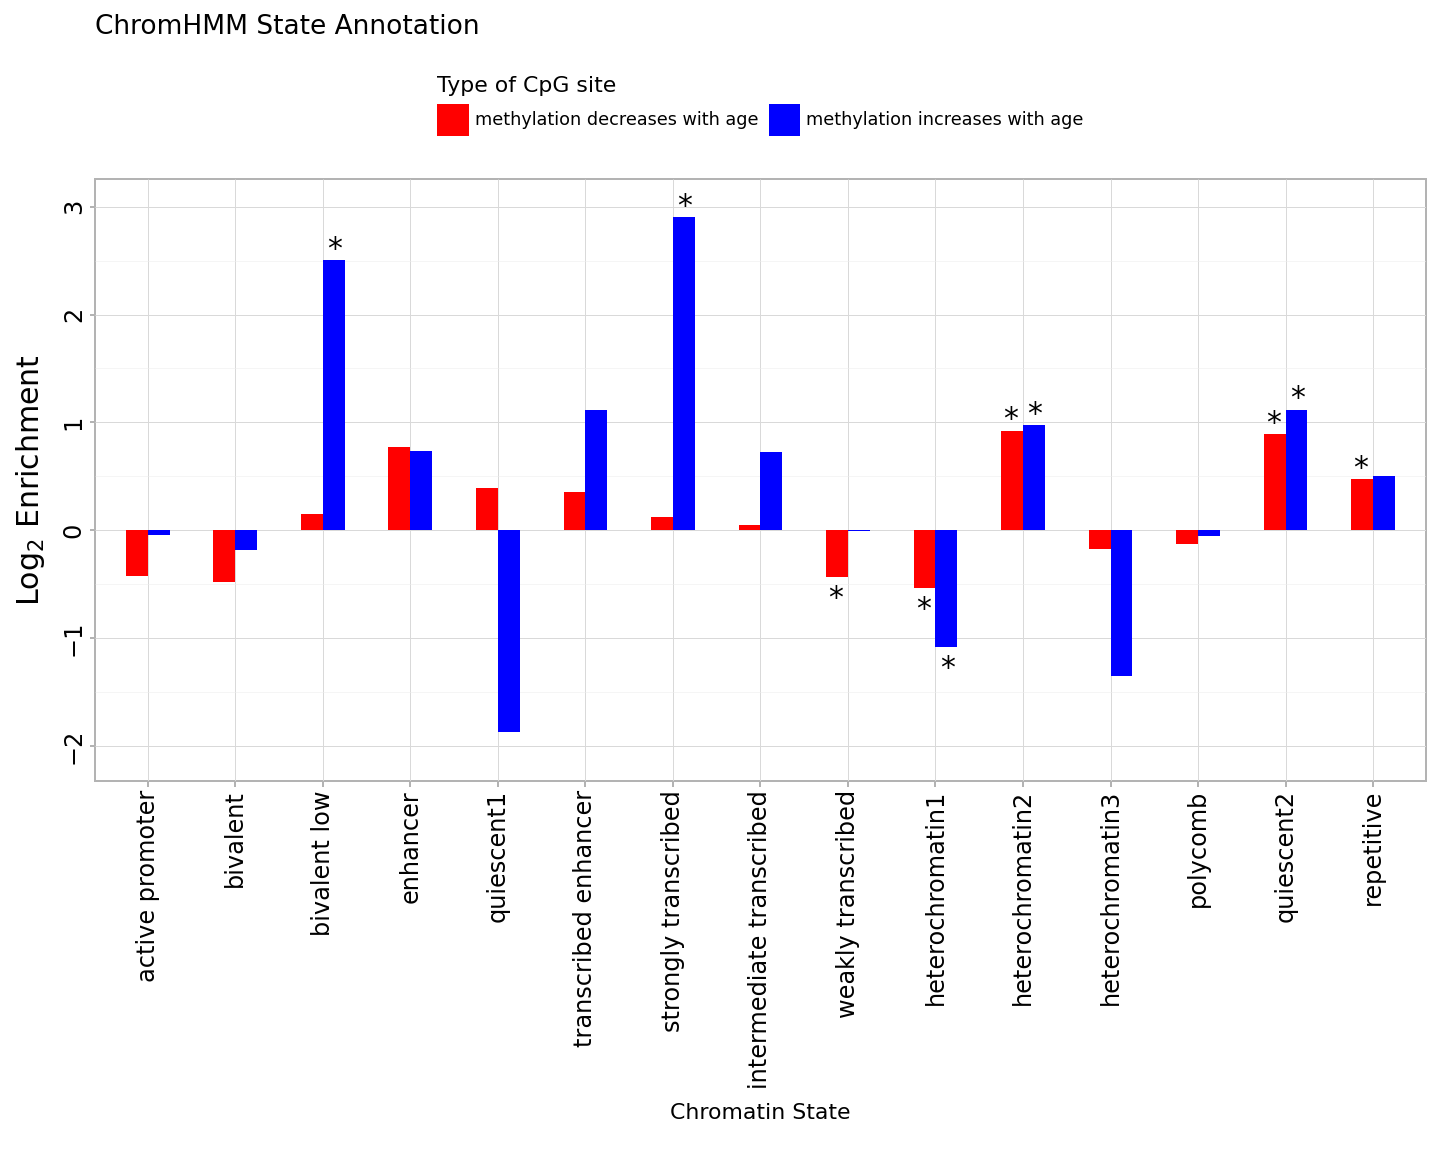

In [2]:
# Generate figure 3
chromhmm_segments = pb.BedTool(filenames.CHROMHMM_SEGMENTATION_BED)

# counters  eg  { 'E4': 88, ... }
pos_counts = Counter([anno[-1] for anno in pos_cpgs.intersect(chromhmm_segments, wb=True)])
neg_counts = Counter([anno[-1] for anno in neg_cpgs.intersect(chromhmm_segments, wb=True)])
all_counts = Counter([anno[-1] for anno in all_tbs_cpgs.intersect(chromhmm_segments, wb=True)])

E_annotation = {
    'E1': 'heterochromatin1', 
    'E2': 'heterochromatin2',
    'E3': 'repetitive',
    'E4': 'quiescent2',
    'E5': 'heterochromatin3',
    'E6': 'polycomb',
    'E7': 'bivalent',
    'E8': 'quiescent1',
    'E9': 'enhancer',
    'E10': 'transcribed enhancer',
    'E11': 'weakly transcribed',
    'E12': 'strongly transcribed',
    'E13': 'intermediate transcribed',
    'E14': 'bivalent low',
    'E15': 'active promoter'}

labels = [f"E{i}" for i in range(1,len(pos_counts)+1)]
pos_df = pd.DataFrame({'state': labels,'name': [E_annotation[lab] for lab in labels], 'count': [pos_counts[lab] for lab in labels], 'type': 'pos'})
neg_df = pd.DataFrame({'state': labels,'name': [E_annotation[lab] for lab in labels], 'count': [neg_counts[lab] for lab in labels], 'type': 'neg'})
all_df = pd.DataFrame({'state': labels,'name': [E_annotation[lab] for lab in labels], 'count': [all_counts[lab] for lab in labels], 'type': 'all'})

for df in [pos_df, neg_df, all_df]:
    s = df['count'].sum()
    df["ratio"] = df["count"].apply(lambda x: x / s)
for df in [pos_df, neg_df]:
    df['enrichment'] = df['ratio'] / all_df['ratio']
    df['log_enrichment'] = np.log2(df['enrichment'])

def compute_fisher(test_counts, baseline_counts, labels):
    ps = []
    bons = []
    ors = []
    for k in labels:
        # Create a 2x2 table for each category. 
        # E.g for the chromatin state k:
        #                  in k                  not in k
        #  pos CpGs   | num pos cpgs in k  |  num pos cpgs not in k  |
        #  all Cpgs   | num all cpgs in k  |  num all cpgs not in k  |
        #                -------------------    ----------------  
        table = [[test_counts[k], sum(test_counts.values()) - test_counts[k]],
                [baseline_counts[k], sum(baseline_counts.values()) - baseline_counts[k]]]
        oddsratio, p_value = stats.fisher_exact(table)
        bon = min(p_value*len(pos_counts), 1.0)
        # print(f"{k} {E_annotation[k]}: Odds Ratio: {oddsratio}, P-value: {p_value}, Bonferroni P: {bon}")
        ors.append(oddsratio)
        ps.append(p_value)
        bons.append(bon)
        
    bhs = stats.false_discovery_control(ps)
    return ps, bons, bhs, ors

pos_df['p'], pos_df['p_adj_bonf'], pos_df['p_adj_bh'], pos_df['oddsratio'] = compute_fisher(pos_counts, all_counts, labels)
neg_df['p'], neg_df['p_adj_bonf'], neg_df['p_adj_bh'], neg_df['oddsratio'] = compute_fisher(neg_counts, all_counts,labels)
for df in [pos_df, neg_df]:
    df['stars'] = df['p_adj_bh'].apply(lambda x: '*' if x < 0.05 else '')
    fdrs = []
    for p_adj, log_enrichment in zip(df['p_adj_bh'], df['log_enrichment']):
        s = 1 if log_enrichment > 0 else -1
        fdrs.append(s*-1*np.log10(p_adj))
    df['signed_neg_log10_p_adj_bh'] = fdrs

# display(pos_df)
melted_df = pd.concat([pos_df, neg_df])
melted_df['nudge_direction'] = melted_df['log_enrichment'].apply(lambda x: 0.1 if x > 0 else -0.2)

state_order = [ 'E15', 'E7', 'E14', 'E9', 'E8', 'E10', 'E12', 'E13', 'E11', 'E1', 'E2', 'E5', 'E6', 'E4', 'E3' ]
names_order = [melted_df[melted_df['state'] == state]['name'].values[0] for state in state_order]
melted_df['name'] = pd.Categorical(melted_df['name'], categories=names_order, ordered=True)

display(melted_df)

plot = (ggplot(melted_df, aes(x='name', y='log_enrichment', fill='type'))
        + geom_bar(stat="identity", position=position_dodge(width=0.5), width=0.5)
        + theme_light()
        + geom_text(aes(label='stars', y='log_enrichment + nudge_direction'), position=position_dodge(width=0.55), size=15)
        + scale_fill_manual(values={"neg": "red", "pos": "blue"},
                            name="Type of CpG site",
                            labels={"neg": "methylation decreases with age",
                                    "pos": "methylation increases with age"})
        + theme(figure_size=(10, 8))
        + labs(x="Chromatin State", title="ChromHMM State Annotation")
        + theme(legend_position='top', axis_text_x=element_text(angle=90, vjust=1, hjust=0.5, size=12, color="black"),
                axis_text_y=element_text(angle=90, size=12, color="black"),
                axis_title_y=element_text(size=15))
        + labs(y="Log$_{2}$ Enrichment"))

plot.draw()

In [9]:
pos_df['count']

0     80
1     61
2     35
3     57
4      4
5      7
6      8
7      1
8      3
9     11
10    27
11    14
12     9
13     7
14     2
Name: count, dtype: int64

In [7]:
all_df['count']

0     13171
1      2419
2      1914
3      2040
4       792
5       564
6       705
7       283
8       140
9       396
10     2112
11      146
12      424
13       96
14      160
Name: count, dtype: int64

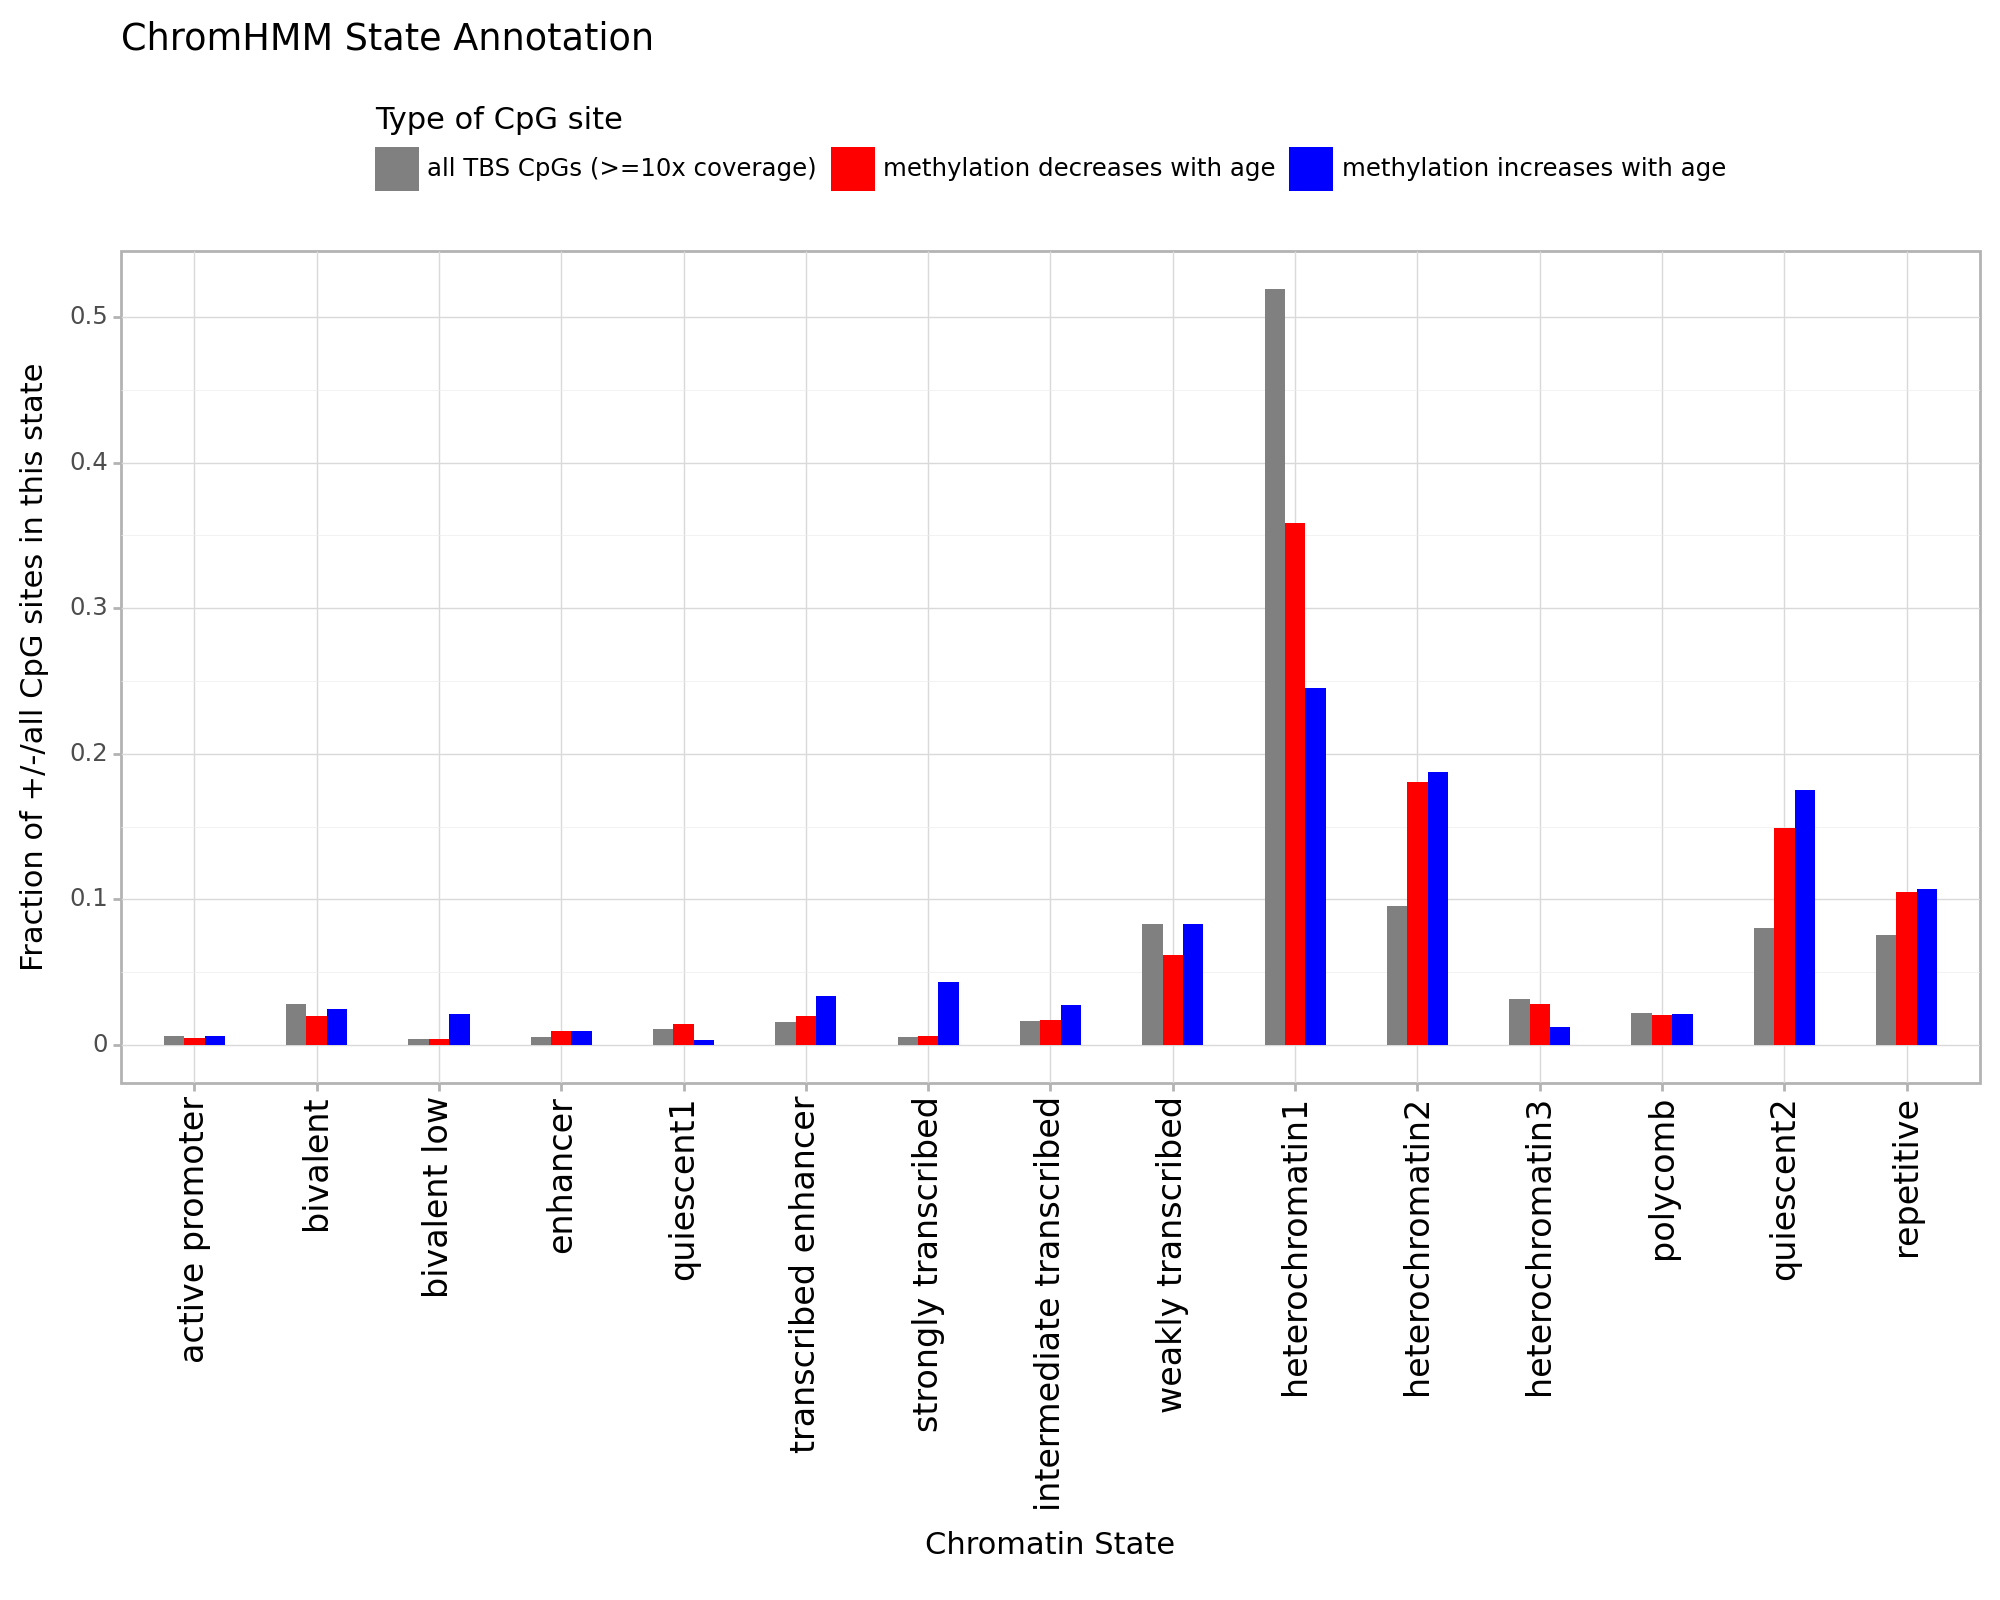

In [4]:
# Generate supplementary figure 6
melted_df2 = pd.concat([melted_df, all_df])
melted_df2['name'] = pd.Categorical(melted_df2['name'], categories=names_order, ordered=True)
plot = (ggplot(melted_df2, aes(x='name', y='ratio', fill='type'))
        + geom_bar(stat="identity", position=position_dodge(width=0.5), width=0.5)
        + theme_light()
        + scale_fill_manual(values={"neg": "red", "pos": "blue", "all": "gray"},
                            name="Type of CpG site",
                            labels={"neg": "methylation decreases with age",
                                    "pos": "methylation increases with age",
                                    "all": "all TBS CpGs (>=10x coverage)"})
        + theme(figure_size=(10, 8))
        + labs(x="Chromatin State", y="Fraction of +/-/all CpG sites in this state", title="ChromHMM State Annotation")
        + theme(legend_position='top', axis_text_x=element_text(angle=90, vjust=1, hjust=0.5, size=12, color="black")))

plot.draw()